In [ ]:
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

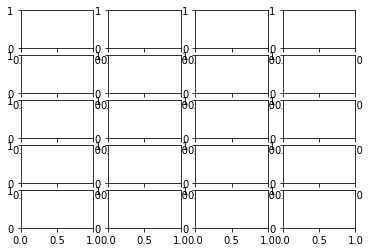

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

global process_img
global epoch_one
global img_size
global left_fit
global right_fit
global left_fitx
global right_fitx
global init_lr_fit
#last frame's fit lines
# variables to remember from first pass
init_lr_fit = tuple()
last_fit = tuple()
last_fitx = tuple()
#boolean for first pass
epoch_one = False
ploty = np.empty(0)
img_size = tuple()

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

plt.subplots(5,4 )

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print(corners)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        
        
        
    
        
        
cv2.destroyAllWindows()

Text(0.5,1,'Undistorted Image')

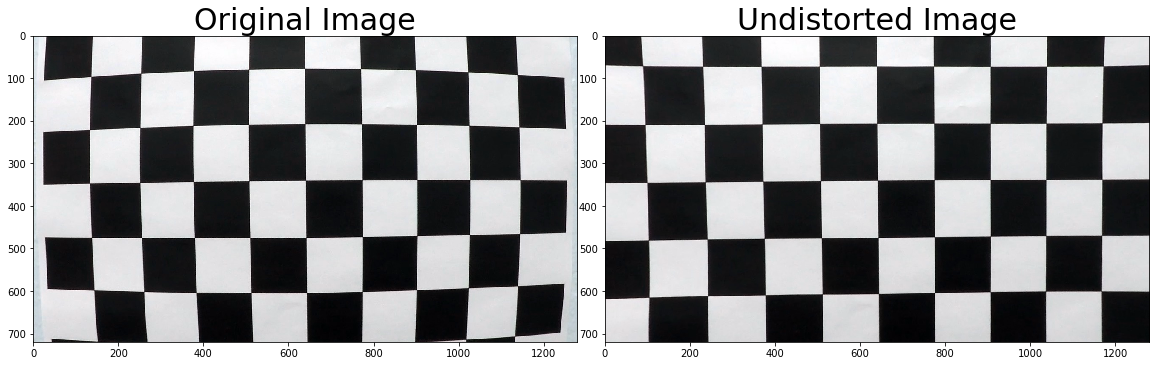

In [2]:
import os
# Performs the camera calibration and image undistortion 
#while not os.path.isfile("../camera_cal/calibration01.jpg"):
    #print('not present')

img = cv2.imread('./camera_cal/calibration1.jpg')
imgsize = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgsize,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


In [4]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_radius(result, warp, left_fit,right_fit): #_fit, r_fit, l_lane_inds, r_lane_inds):
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 
    y_eval = np.max(ploty)
    midx = 650
    
    lfit_x = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    rfit_x = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    
    left_rad = ((1 + (2*lfit_x[0]*y_eval*ym_per_pix + lfit_x[1])**2)**1.5) / np.absolute(2*lfit_x[0])
    right_rad = ((1 + (2*rfit_x[0]*y_eval*ym_per_pix + rfit_x[1])**2)**1.5) / np.absolute(2*rfit_x[0])

    
    cv2.putText(result,'Radius: Left= %.2fm' % left_rad + ',  Right= %.2fm' % right_rad ,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    left_pixX = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    right_pixX = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    dist_center = ((left_pixX + right_pixX)/2 - midx) * xm_per_pix
    if dist_center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(dist_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    
    
    


In [5]:
def draw_lane(original_img, warp, l_fit, r_fit, Minv):
    ploty = np.linspace(0, warp.shape[0]-1, warp.shape[0])
    #quadratic_coeff = 3e-4
    warp_zero = np.zeros_like(warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))*255
    
    l_fit = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    r_fit = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([l_fit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    return result



In [8]:

#Undistorit this image
def undistort(img):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img


def corners_unwarp():
    global img_size
    #src = np.float32([[    (img_size[1]/4)-50,   img_size[0]-20],[ img_size[1]-80,   img_size[0]-20],[  ((img_size[1]/2)+140),   (2*img_size[0]/3)],[  (.4*img_size[1])-32,   (2*img_size[0]/3)]])
    #dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],[img_size[1],0],[0,0]])
    src = np.float32([[545,460],
                     [735,460],
                     [1280,700],
                     [0,700]])
    dst = np.float32([[0,0],
                     [1280,0],
                     [1280,720],
                     [0,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M,Minv

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(200, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

def LAB_Bthresh(img, thresh=(170,200)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    if np.max(b_channel) > 175:
       lab_b = b_channel*(255/np.max(b_channel))
    # 2) Apply a threshold to the L channel
    b_output = np.zeros_like(b_channel)
    b_output[((b_channel > thresh[0]) & (b_channel <= thresh[1]))] = 1
    return b_output


def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174,250])
    mask = cv2.inRange(hsv, lower, upper)
    return mask
    
def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image,lower,upper)
    return mask

def comb_thresh(image):
    yellow = select_yellow(image)
    white = select_white(image)
    
    combined_binary = np.zeros_like(yellow)
    combined_binary[(yellow >=1) | (white >=1 )] = 1
    return combined_binary


def lane_pipeline(image):
    M, Minv = corners_unwarp()
    img = undistort(image)
    
    imgsize = img_size[1],img_size[0]
    
    #### HLS + B ###
    b_binary= LAB_Bthresh(img)
    # Threshold color channel
    l_binary = hls_select(img)
    
    color_binary = np.dstack(( np.zeros_like(b_binary), b_binary, l_binary)) * 255
    
    #combined_binary = np.zeros_like(b_binary)
    #combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    combined_binary = comb_thresh(img) 

    image = cv2.warpPerspective(combined_binary, M, imgsize , flags=cv2.INTER_LINEAR)
    return M, Minv, img,image
    #return combined_binary

     

def pipeline(img):

    global process_img
    global epoch_one
    global img_size
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    global init_lr_fit
    global ploty
    
    img_size = img.shape
    
    M,Minv, original, warped = lane_pipeline(img)
    #plt.imshow(warped)

    if not epoch_one:
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        process_img = np.dstack((warped, warped, warped))*255
        
        # Use histogram to find the left and right peaks for the lane
        histogram = np.sum(warped[:,:], axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        margin = 100
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        # Choose the number of sliding windows
        nwindows = 9
        minpix = 30
        # Set height of windows
        window_height = np.int(warped.shape[0]/nwindows)
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped.shape[0] - (window+1)*window_height
            win_y_high = warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(process_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(process_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print(left_fit,right_fit)
        last_fit = (left_fit,right_fit)
        init_lr_fit = (left_fit,right_fit)

        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        epoch_one = True
        last_fitx = (left_fitx,right_fitx)

        process_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        process_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        y_eval = 700

        y_eval = np.max(ploty)
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        newimg = cv2.warpPerspective(color_warp, Minv, (original.shape[1], original.shape[0])) 
        final = cv2.addWeighted(original, 1, newimg, 0.3, 0)
        
    else:
        
        nonzero = warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        
        left_fit,right_fit = init_lr_fit[0],init_lr_fit[1]
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        if (leftx.size>50)and(lefty.size>50)and(rightx.size>50)and(righty.size>50):

            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            last_fit = (left_fit,right_fit)
        else:
            left_fit, right_fit = last_fit[0], last_fit[1]
       
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        
        process_img = np.dstack((warped, warped, warped))*255
        window_img = np.zeros_like(process_img)
       
        process_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        process_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    final = draw_lane(original, warped, left_fit, right_fit, Minv)
    calc_radius(final, warped, left_fit,right_fit)
    
    
    return final

#Img = cv2.imread('./test_images/test4.jpg')
#final_img = pipeline(Img) 
#plt.imshow(final_img)

In [9]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video = 'project_video_out.mp4'
clip = VideoFileClip("project_video.mp4")
process_clip = clip.fl_image(pipeline)
%time process_clip.write_videofile(video, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [05:09<00:00,  2.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 2min 12s, sys: 2 s, total: 2min 14s
Wall time: 5min 15s
